In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [2]:
#Plotting functions taken from the Tracr repo 

#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)

## Basic Testing

In [3]:
#Return the input in reverse
def reverse() -> rasp.SOp:
    length = lib.make_length()
    opp_index = length - rasp.indices - 1
    flip = rasp.Select(rasp.indices, opp_index, rasp.Comparison.EQ)
    return rasp.Aggregate(flip, rasp.tokens)

reverse_model = compiling.compile_rasp_to_model(reverse(), {0,1,2,3,4}, 7, compiler_bos="BOS")

#Model length does not include bos token

In [4]:
reverese_output = reverse_model.apply(["BOS",1,4,3,0,0,0,1])
print(reverese_output.decoded)
#reverese_output.attn_logits
#reverese_output.input_embeddings
#reverese_output.layer_outputs
#reverese_output.residuals

['BOS', 1, 0, 0, 0, 3, 4, 1]


In [5]:
#Testing atoi and adding indices to input

#If atoi is used all inputs need to be str
def atoi() -> rasp.SOp:
    return rasp.Map(lambda x: ord(x)-ord("0"), rasp.tokens)

def addIndicesAtoi() -> rasp.SOp:
    return rasp.indices + atoi()

def addIndices() -> rasp.SOp:
    #return rasp.indices + atoi()
    return rasp.indices + rasp.tokens

addIndicesModel = compiling.compile_rasp_to_model(addIndicesAtoi(), {"0","1","2","3","4","+"}, 5, compiler_bos="BOS")
print(addIndicesModel.apply(["BOS", "4","3","1","2"]).decoded)
#Gives output as int even though it does not accept int as input
#Aka can give ouputs not specified in input domain (At least numeric)

addIndicesModel = compiling.compile_rasp_to_model(addIndices(), {1,2,3,4}, 5, compiler_bos="BOS")
print(addIndicesModel.apply(["BOS", 4,3,1,2]).decoded)

#addIndicesModel = compiling.compile_rasp_to_model(addIndices(), {"0","1","2","3","4","+",0}, 5, compiler_bos="BOS")    
#Will not compile due to to compiler failing to compare number with str in atoi (during feasibility check?)

['BOS', 4, 4, 3, 5]
['BOS', 4, 4, 3, 5]


## Trying to create addition model based on my RASPy implementation

I know this worked before but now it uses + instead of _ (¤_¤)

Every step except the last seems correct when looking at the residuals. It seems to me that it does not apply the manual default but instead adds "None" which causes it to use a "undesired" token instead of the token I have designated as the default

If doing aggIndCat == False it correctly applies _ (but in the opposite positions ofc). Doing aggIndCat != False does not work either. Fuck this shit

The question to solve is why the "default" values are not actually the values that the SequenceMap should give according to the residuals

Re-read the segment in the Paper about how to read the residuals to see if I have missed some vital information

Is the order in the output stream relevant? It would be stupid if the order which I cannot influence dictates what is possible

['BOS', '+', '+', '1', '3', '_']
TransformerConfig(num_heads=1, num_layers=4, key_size=9, mlp_hidden_size=17, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x000001A42D41D7C0>, layer_norm=False, causal=False)


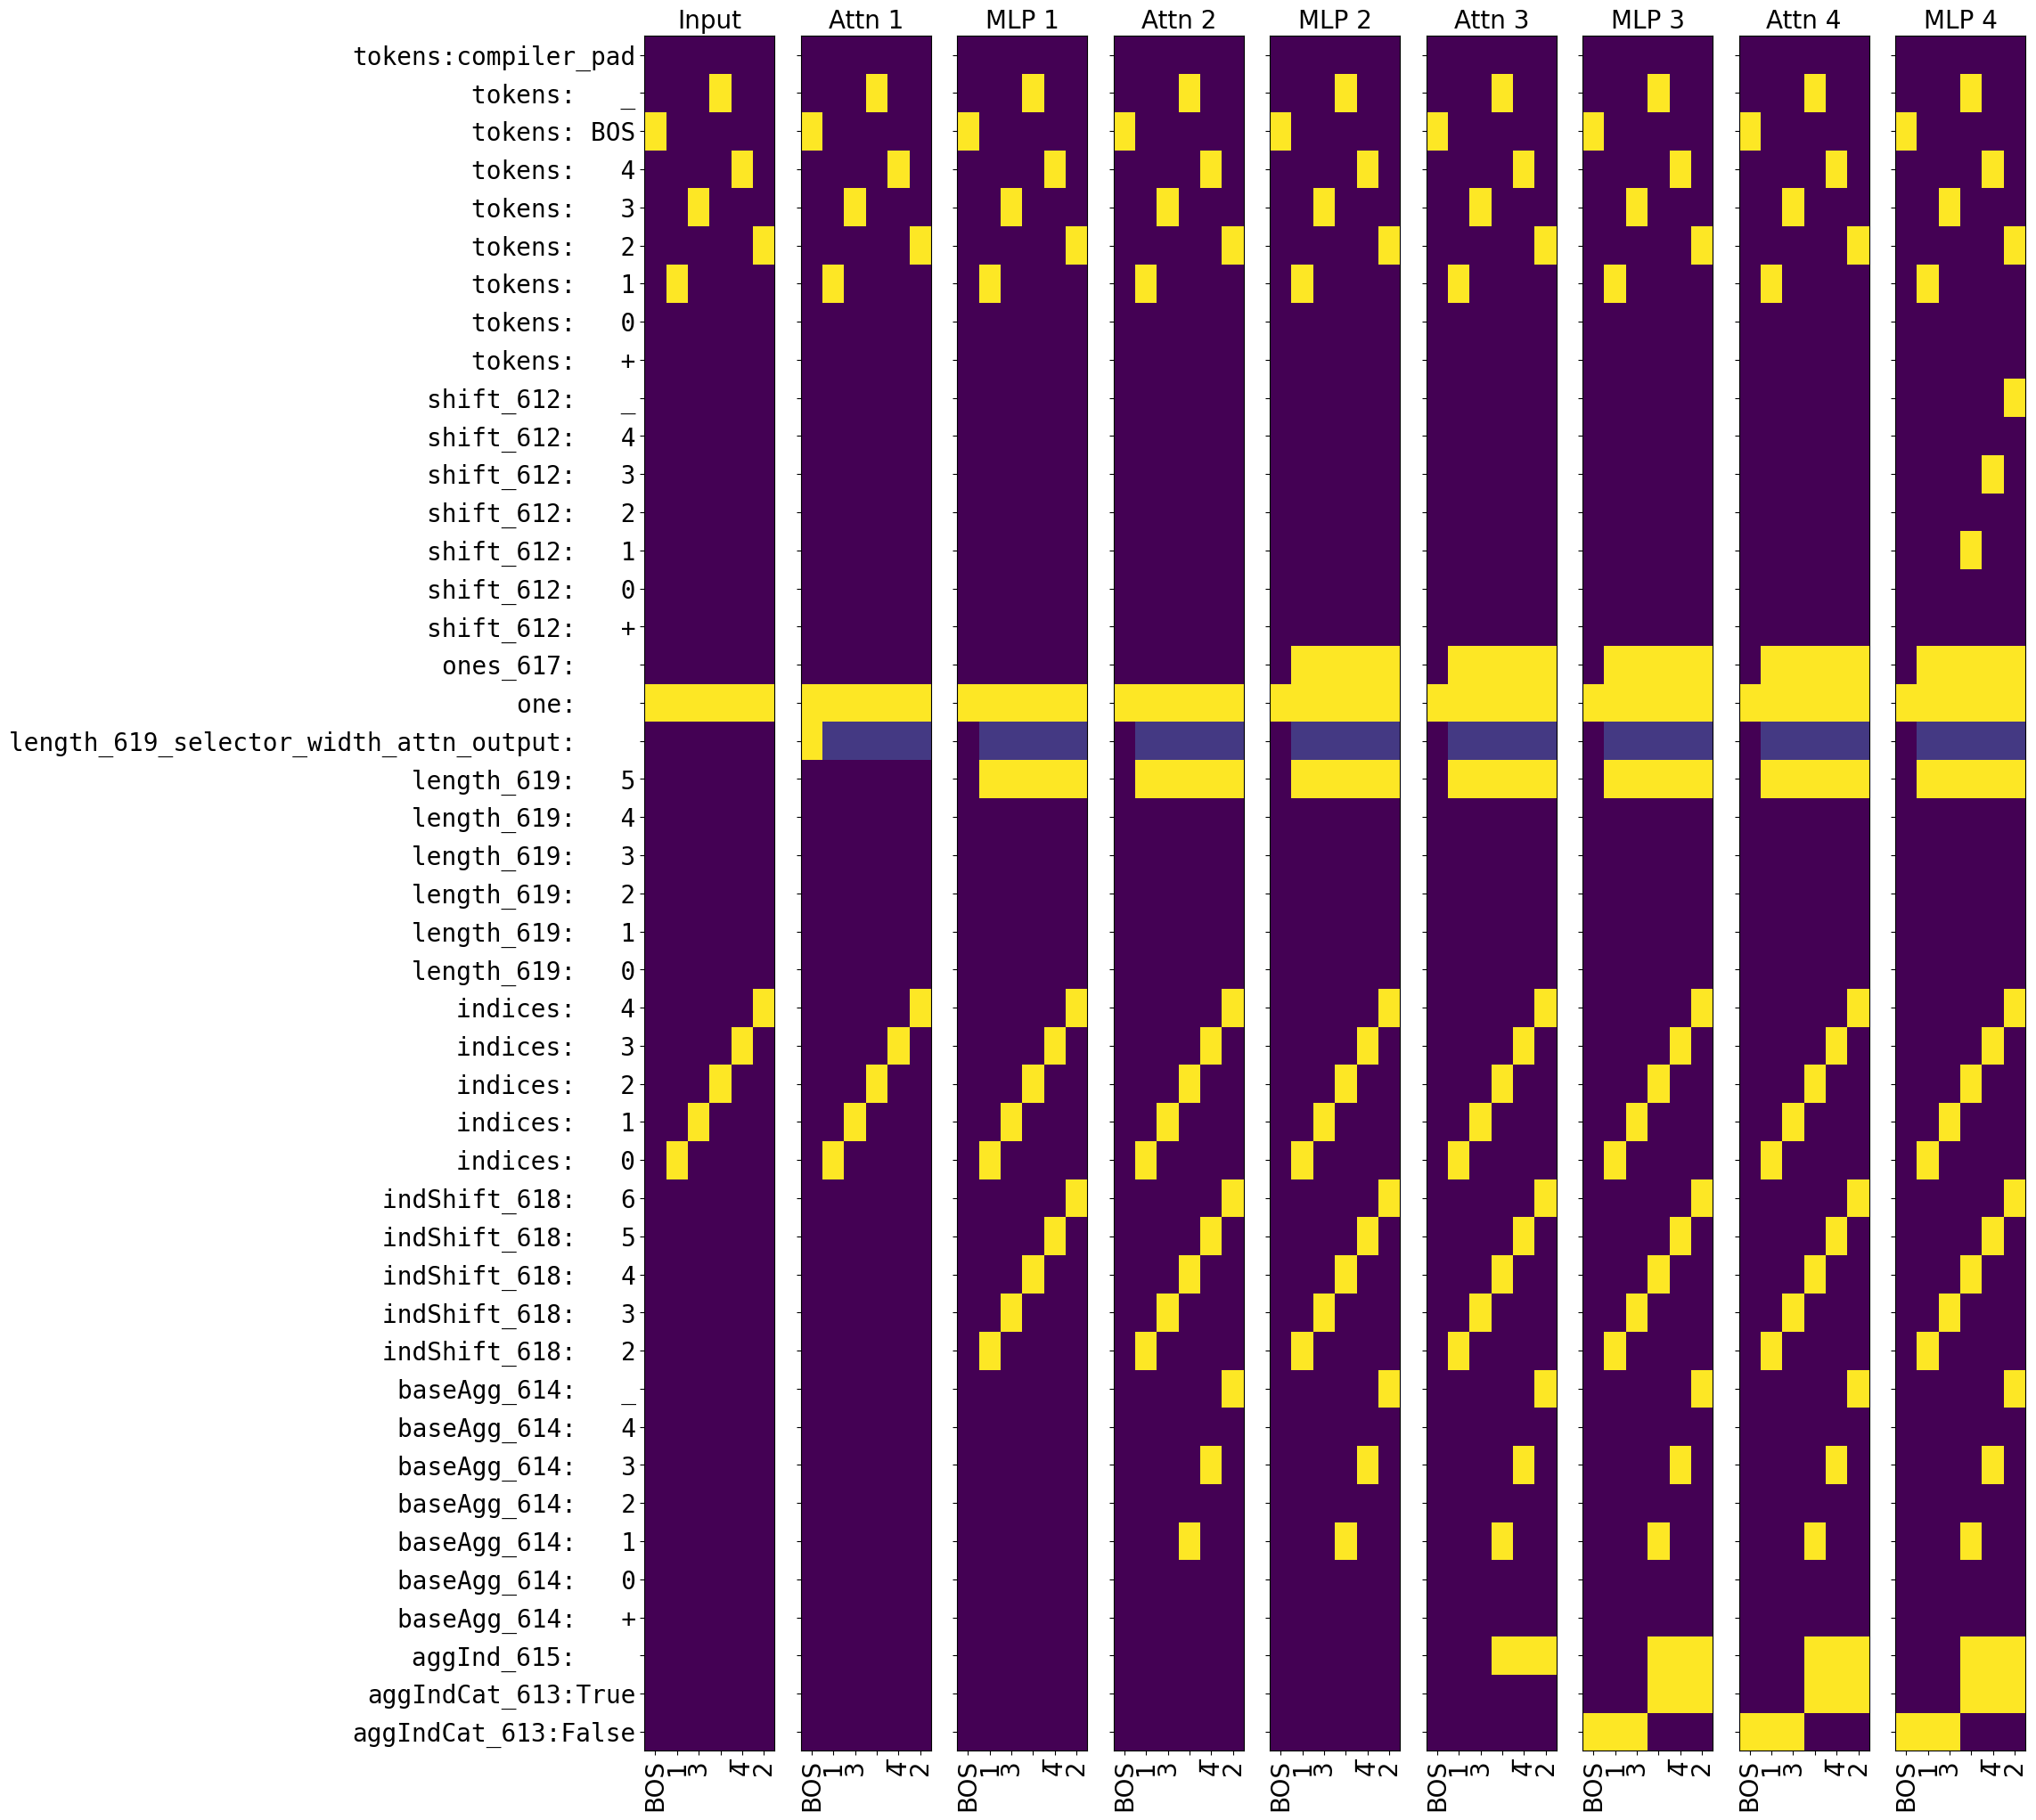

: 

In [50]:
#Since the default does not work in a useful way I made my own version
def defaultAggregate(sel: rasp.Selector, value: rasp.SOp, default="_") -> rasp.SOp:
    length = lib.make_length().named("length")
    ones = rasp.numerical(rasp.Map(lambda x: 1, length)).named("ones")
    aggInd = rasp.numerical(rasp.Aggregate(sel, ones, default=0)).named("aggInd")
    #Need to be categorical as SequenceMap only need both SOp to be same class
    #There seem to be major misscalculations in the actual value of aggInd since x>0.1 gives false results
    #   will likely lead to major bugs at some point (:
    aggIndCat = rasp.Map(lambda x: x > 0.5, aggInd).named("aggIndCat")
    baseAgg = rasp.Aggregate(sel, value).named("baseAgg")
    return rasp.SequenceMap(lambda x,y: y if x == True else default, aggIndCat, baseAgg).named("defaultAggregate")

#Shifts the sequence i steps to the right and fills with default token
def shift(i=1, default="_") -> rasp.SOp:
    indShift = (rasp.indices + i).named("indShift")
    shiftMask = rasp.Select(indShift, rasp.indices, rasp.Comparison.EQ).named("shiftMask")  
    #Implement manual default since Tracr does not seem to allow custom default tokens
    return defaultAggregate(shiftMask, rasp.tokens, default=default).named("shift")

    #A more efficient version which they use in rasp.lib
    #Circumvents the extra mlp (indShift) by adding directly in the Select function logic
    #select_off_by_offset = rasp.Select(rasp.indices, rasp.indices,
    #                                    lambda k, q: q == k + offset)
    #out = rasp.Aggregate(select_off_by_offset, sop, default=None)
    #return out.named(f"shift_by({offset})")

#Testing
shiftModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+","_"}, 5, compiler_bos="BOS")
#shiftModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+"}, 5, compiler_bos="BOS") #default,"_", needs to be included in the allowed input in order to be encoded correctly
model = shiftModel
input = ["BOS","1","3","_","4","2"]
print(model.apply(input).decoded)
print(model.model_config)

plot_residuals_and_input(model=model, inputs=input, figsize=(20, 25))

#plot_layer_outputs(model=model, inputs=input, figsize=(10, 9))

['BOS', 1, 1, 1, 1]


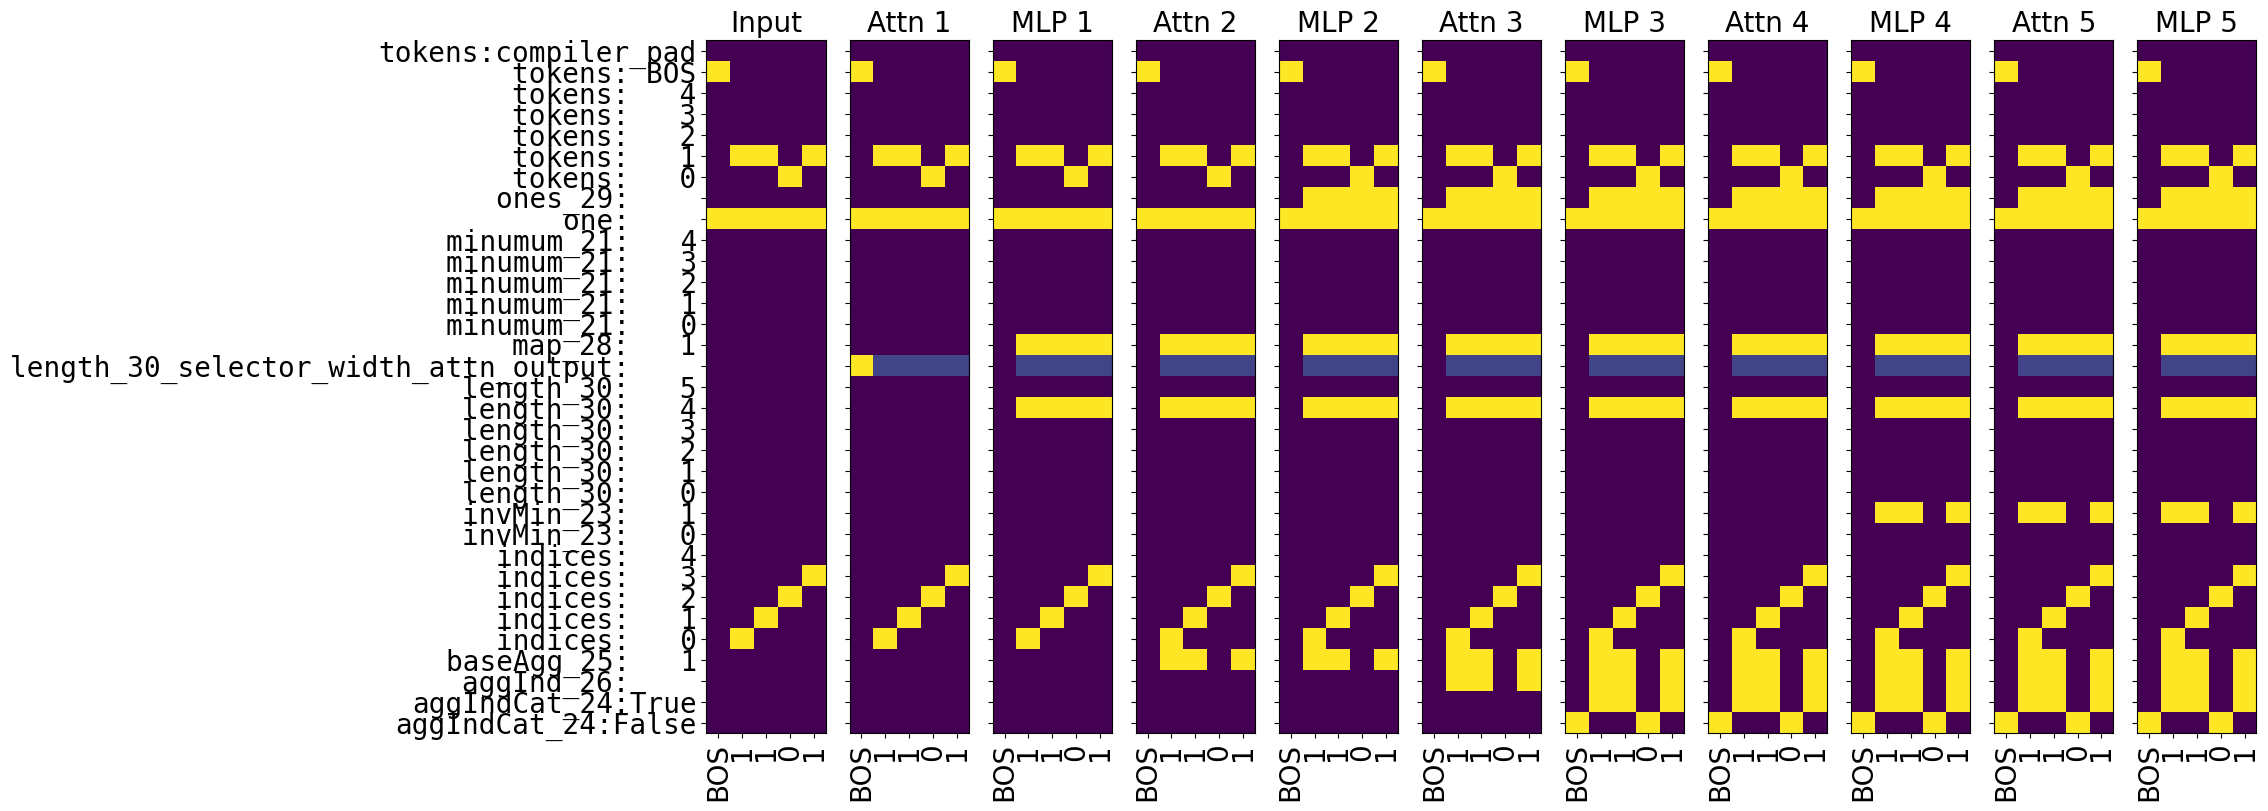

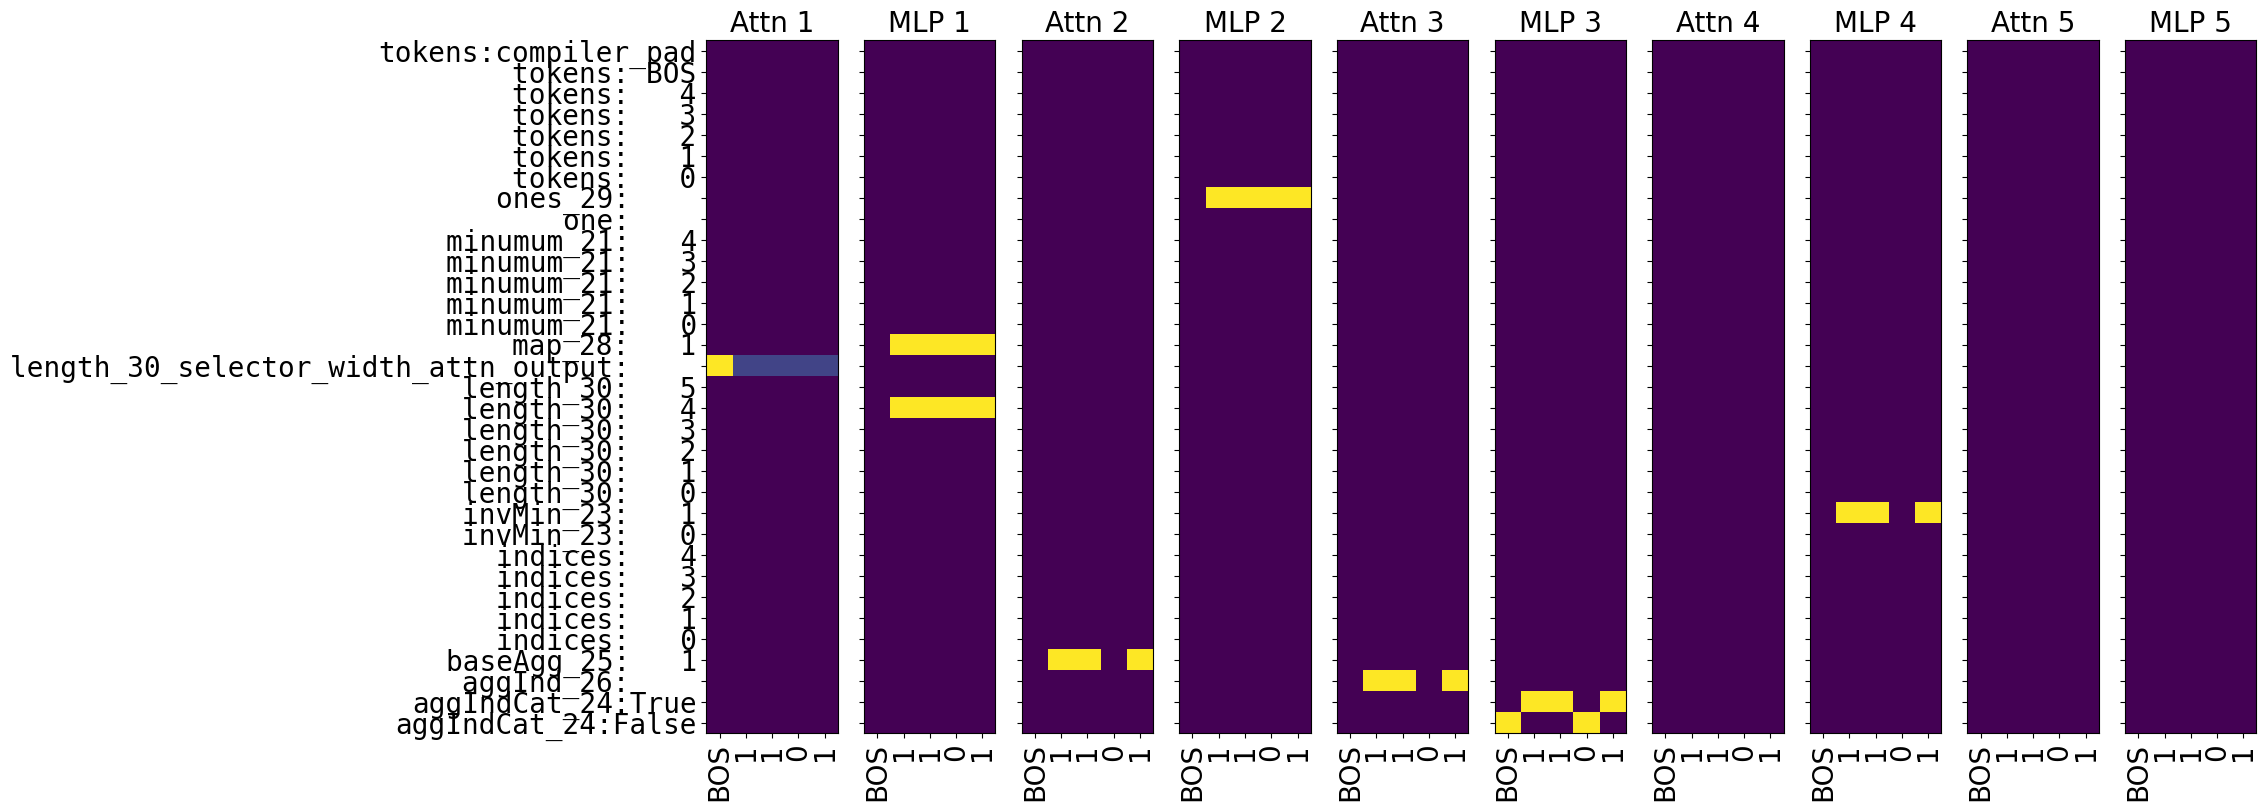

In [7]:
def temp1(seq=rasp.tokens) -> rasp.SOp:
    selector = rasp.Select(seq, seq, rasp.Comparison.LT)
    invMin = defaultAggregate(selector, rasp.Map(lambda x: 1, seq), default=0).named("invMin")
    return invMin

#Testing the second part seperately from the first part with the output of the first part as input it seems to work
#When testing the two parts at the same time it does not work, why? Calculating in the wrong order?
def temp2(seq=rasp.tokens, ind=rasp.indices) -> rasp.SOp:
    minSelector = rasp.Select(seq, seq, lambda x,y: x==0)
    minValue = rasp.Aggregate(minSelector, ind) #When testing like this it does add to the output stream
    return minValue.named("temp2")

#Return a vector with the smalest number in seq
def minimum(seq=rasp.tokens) -> rasp.SOp:
    selector = rasp.Select(seq, seq, rasp.Comparison.LT)
    invMin = defaultAggregate(selector, rasp.Map(lambda x: 1, rasp.indices), default=0).named("invMin")
    #return invMin
    minSelector = rasp.Select(invMin, invMin, lambda x,y: x == 0)
    minValue = rasp.Aggregate(minSelector, rasp.tokens) #It seems this one is never adding to the output stream
    return minValue.named("minumum")


minimumModel = compiling.compile_rasp_to_model(temp2(rasp.tokens, rasp.indices), {0,1,2,3,4}, 5, compiler_bos="BOS")
minimumModel = compiling.compile_rasp_to_model(minimum(rasp.tokens), {0,1,2,3,4}, 5, compiler_bos="BOS")
#minimumModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+"}, 5, compiler_bos="BOS")
model = minimumModel
input = ["BOS",2,1,2,3]
input = ["BOS",1,1,0,1]
print(model.apply(input).decoded)

plot_residuals_and_input(model=model, inputs=input, figsize=(20, 9))

plot_layer_outputs(model=model, inputs=input, figsize=(20, 9))

#### Showcasing the minimum problem

['BOS', 1, 1, 0, 1]
['BOS', 2, 2, 2, 2]
['BOS', 0, 0, 0, 0]


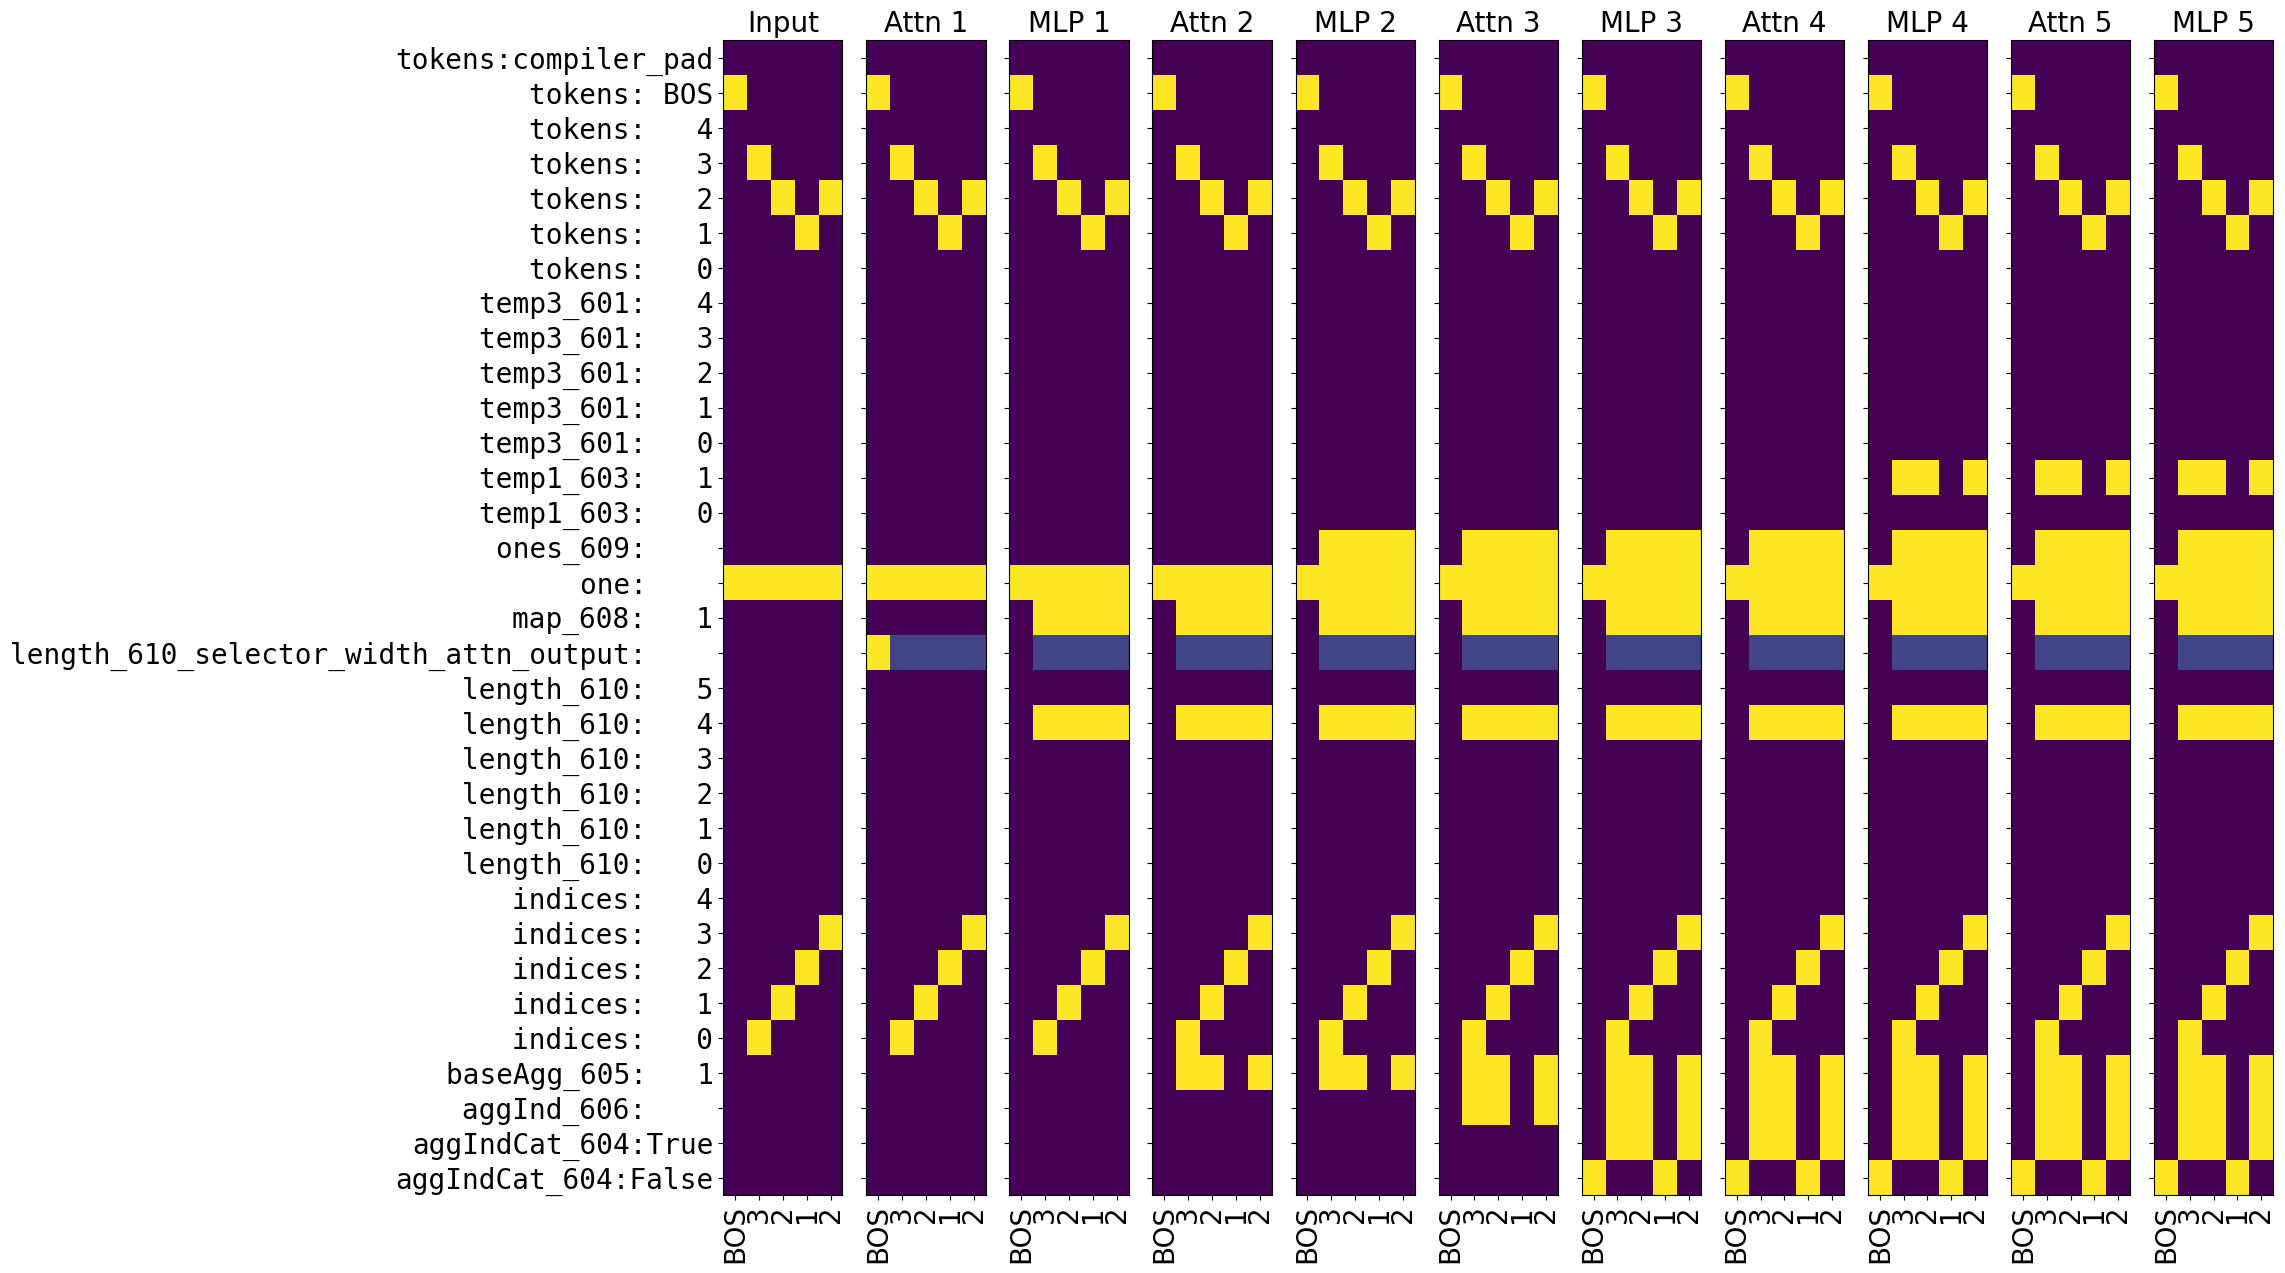

In [49]:
#Returns a boolean mask of the values which are not the minimum
def temp1(seq=rasp.tokens) -> rasp.SOp:
    selector = rasp.Select(seq, seq, rasp.Comparison.LT)
    invMin = defaultAggregate(selector, rasp.Map(lambda x: 1, seq), default=0).named("temp1")
    return invMin

temp1model = compiling.compile_rasp_to_model(temp1(rasp.tokens), {0,1,2,3,4}, 5, compiler_bos="BOS")
print(temp1model.apply(["BOS",3,2,1,2]).decoded)
#Returns the correct mask 1101

#Returns the token in "ind" where "seq" is 0
def temp2(seq=rasp.tokens, ind=rasp.indices) -> rasp.SOp:
    minSelector = rasp.Select(seq, seq, lambda x,y: x==0)
    minValue = rasp.Aggregate(minSelector, ind)
    return minValue.named("temp2")

temp2model = compiling.compile_rasp_to_model(temp2(rasp.tokens, rasp.indices), {0,1,2,3,4}, 5, compiler_bos="BOS")
print(temp2model.apply(["BOS",1,1,0,1]).decoded)
#Returns 2222 which is the third token in indices and the expected result

#Should return the result of temp2 on the results of temp1
def temp3(seq=rasp.tokens) -> rasp.SOp:
    invMin = temp1(seq)
    minValue = temp2(invMin, rasp.indices)
    return minValue.named("temp3")

temp3model = compiling.compile_rasp_to_model(temp3(rasp.tokens), {0,1,2,3,4}, 5, compiler_bos="BOS")
print(temp3model.apply(["BOS",3,2,1,2]).decoded)
#Returns 0000 which is is not correct. 0000 corresponds might correspond to it choosing the first token or it might be a "None" value in a aggregate function

plot_residuals_and_input(model=temp3model, inputs=["BOS",3,2,1,2], figsize=(20, 15))
#Looking at the residual stream it seems as if temp3 never outputs anything which would suggest it default to "None" in aggregate
#   Why the hell would it do this?
#       defaultAggregate which worked before is broken now so that might be the cause. Although this is unlikely due to the residual stream showing
#       that the defaultAggregate output (temp1) is correct


In [9]:
#Computes the first index of token 'q'
def firstSimple(q, seq: rasp.SOp) -> rasp.SOp:
    targetTokens = (seq == q).named("targetTokens") #Boolean mask
    selectTargets = rasp.Select(targetTokens, rasp.indices, lambda x,y: x==True).named("selectTargets")   #Targets selected tokens

    return rasp.Aggregate(selectTargets, rasp.indices).named("first")   #Utilizes my theory that Tracr returns the smalest value when selecting multiple categoricals
    #This works in Tracr (I think) but it does not work in RASPy i.e. depends on RASP implementation
        #It seems to work in simple cases but I suspect it can fail in more complicated cases e.g. when calling from another function or using tokens outside of seq in calculation chain

#Computes the first index of token 'q'
def first(q, seq: rasp.SOp) -> rasp.SOp:
    return minimum()

firstModel = compiling.compile_rasp_to_model(firstSimple("+", rasp.tokens), {"0","1","2","3","4","+","_"}, 5, compiler_bos="BOS")
#firstModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+"}, 5, compiler_bos="BOS")
model = firstModel
input = ["BOS","1","3","+","4","+"]
print(model.apply(input).decoded)

#plot_residuals_and_input(model=model, inputs=input, figsize=(10, 9))

#plot_layer_outputs(model=model, inputs=input, figsize=(10, 9))

['BOS', 2, 2, 2, 2, 2]


In [10]:
#Right aligns a sequence padded with _ and pads with default
def ralign(default="¨", seq: rasp.SOp =rasp.tokens) -> rasp.SOp:
    length = lib.make_length()
    offset = first("_",seq).named("ralignOffset")
    #return offset #=3
    #return lib.make_length() #=7
    #return lib.make_length() + offset =10
    #return (0 - offset) #=-6
    #return length - offset #=1 ????????????? Why the hell is this?
    shifted = shift(length-offset, default=default)
    return shifted.named("ralign")

ralignModel = compiling.compile_rasp_to_model(ralign(), {"0","1","2","3","4","+","_","¨"}, 7, compiler_bos="BOS")
#ralignModel = compiling.compile_rasp_to_model(shift(2), {"0","1","2","3","4","+"}, 5, compiler_bos="BOS")
model = ralignModel
input = ["BOS","1","3","+","_","_","_","_"]
print(model.apply(input).decoded)

#plot_residuals_and_input(model=model, inputs=input, figsize=(10, 9))

#plot_layer_outputs(model=model, inputs=input, figsize=(10, 9))

TypeError: unsupported operand type(s) for -: 'int' and 'str'

### Trying to figure out the slide function


In [ ]:
#testing in-built fraction function

tempModel = compiling.compile_rasp_to_model(lib.make_frac_prevs(rasp.tokens=="b"), {"a", "b", "c","True","False"}, 7, compiler_bos="BOS")
model = tempModel
input = ["BOS", "a", "b", "c", "a", "b", "c"]
print(model.apply(input).decoded)

['BOS', 6.676483943880793e-15, 0.5, 0.3333333432674408, 0.25, 0.4000000059604645, 0.3333333432674408]


In [ ]:
#What the heck is happening here? RASPy only return error in when aggregating like this
    #Is it returning the most represented token? Seems like it does when there is a clear leader
    #What does it do when there is no leader? Dont know. It might be picking the "lowest" value since it picks 0 over 1 etc
#Could perhaps be usefull if used when there are clear leaders

#Returns the aggregation of a categorical on a full selection. What does it return? why?
def test() -> rasp.SOp:
    selectAll = rasp.Select(rasp.tokens, rasp.tokens, lambda x,y: True).named("selectAll")
    return rasp.Aggregate(selectAll, rasp.tokens).named("wierdAggregation")

testModel = compiling.compile_rasp_to_model(test(), {"0","1","2","3","4","+","_"}, 6, compiler_bos="BOS")
#testModel = compiling.compile_rasp_to_model(test(), {0,1,2,3,4,5,6}, 5, compiler_bos="BOS") 
model = testModel
input = ["BOS","1","3","+","4","+","_"]
#input = ["BOS",1,3,2,4,5]
print(model.apply(input).decoded)

#plot_residuals_and_input(model=model, inputs=input, figsize=(10, 15))

#plot_layer_outputs(model=model, inputs=input, figsize=(10, 9))

['BOS', '+', '+', '+', '+', '+', '+']


In [ ]:
#cumulative sum of a boolean input
def cumsum(boolean: rasp.SOp) -> rasp.SOp:
    ints = rasp.numerical(boolean)
    cumsumSel = rasp.Select(rasp.indices, rasp.indices, rasp.Comparison.LEQ).named("cumsumSel")
    #return rasp.numerical(rasp.Map(lambda x: x, sop))
    #return rasp.numerical(rasp.Aggregate(cumsumSel, ints, default=0))
    cumsumFrac = rasp.numerical(rasp.Aggregate(cumsumSel, ints, default=0)).named("cumsumFrac")
    cumsumFracCat = rasp.Map(lambda x: x, cumsumFrac)       #This warps the results severely, seems to round down but unclear how much
    return cumsumFracCat
    return cumsumFracCat * (1 + rasp.indices)
    return rasp.SequenceMap(lambda x, y: x * y, cumsumFracCat, rasp.Map(lambda x: x+1,rasp.indices))
    return (cumsumFrac * (rasp.indices+1)).named("cumsum")

#cumsumModel = compiling.compile_rasp_to_model(cumsum(), {"0","1","2","3","4","T","F"}, 5, compiler_bos="BOS")
cumsumModel = compiling.compile_rasp_to_model(cumsum(rasp.tokens == "<"), {"<","x","h","y","l"}, 8, compiler_bos="BOS")
model = cumsumModel
input = ["BOS", "<","<","x","h","y","<","<","l"]
print(model.apply(input).decoded)

#plot_residuals_and_input(model=model, inputs=input, figsize=(10, 15))

['BOS', 1.0, 1.0, 0.5, 0.5, 0.3333333333333333, 0.5, 0.5, 0.5]


In [ ]:
#Shows how aggregate cannot be done with non-binary values
def test() -> rasp.SOp:
    sel = rasp.Select(rasp.indices, rasp.indices, rasp.Comparison.LEQ)
    return rasp.numerical(rasp.Aggregate(sel, rasp.numerical(rasp.indices*10), default=0))

tempModel = compiling.compile_rasp_to_model(test(), {0,1,2,3,4,5}, 5, compiler_bos="BOS")
model = tempModel
input = ["BOS", 3,1,2,4,1]
print(model.apply(input).decoded)

NotImplementedError: ('Attention patterns can currently only average binary variables. Not:', {0, 40, 10, 20, 30})